# Analysis of Nea. ancestry

In [1]:
setwd("../../slim-neanderthal/notebooks/")

In [2]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [4]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [5]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

In [6]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [7]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT_OLD <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den")
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_HO")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_HO.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_HO.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_HO.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_HO")

In [8]:
subset_sites(prefix=EIGENSTRAT_OLD, complement=TRUE, out_prefix=EIGENSTRAT, bed_file="../../nea-over-time/data/bed/bigyri_array.bed")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [9]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

In [10]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai
* O - Chimp


![](img/ice_age_f4_description.png)

In [11]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Nea=c("new_Altai", "new_Vindija")))

In [12]:
my_iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Nea", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

In [13]:
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [14]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [15]:
results <- bind_rows(list(my_iceage_Nea,
                          mbuti,
                          yoruba,
                          dinka)) %>% mutate(name=X, method=setup)

In [16]:
table(results$method)


        qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                 151 
        qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                 151 
       qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                 151 
qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp 
                                                 151 

# Plot Nea. estimates over time

So far we have been focusing on evaluating various scenarios of selection that could reproduce the decrease in Neanderthal ancestry that we reported in the Ice Age paper [@fu_genetic_2016]. As a reminder, this is the slope of Neanderthal ancestry form the paper that we are trying to fit:

In [17]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# combine tables with both estimates into a single table for comparison and merge
# them with counts of SNPs per sample on both admixture array and 2.2M sites arrays
all_nea_estimates <- inner_join(samples, bind_rows(mutate(inner_join(direct_nea, snp_counts_direct), Zscore = Inf),
                                               inner_join(results, snp_counts_f4))) %>%
    select(name, age, pop, alpha, method, snp_count, Zscore) %>% 
    mutate(se=alpha/Zscore)

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"


In [18]:
nea_estimates <- all_nea_estimates %>% 
    filter(pop %in% c("EMH", "WestEurasia"),
                      !name %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                                   "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                      !name %in% non_udg_samples)

In [19]:
nea_estimates %>% filter(name == "UstIshim")

name,age,pop,alpha,method,snp_count,Zscore,se
UstIshim,45020,EMH,0.0284993,direct,157653,Inf,0.000000000
UstIshim,45020,EMH,0.0428530,qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp,1119321,8.821,0.004858066
UstIshim,45020,EMH,0.0190790,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,1119321,4.596,0.004151218
UstIshim,45020,EMH,0.0204930,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,1119321,5.018,0.004083898
UstIshim,45020,EMH,0.0230330,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,1119321,5.857,0.003932559


In [20]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * se, ymax=alpha + x * se, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > 3), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) +
        ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) } %>% 
    summary
}

## Results from the Ice Age paper

In [21]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3408492   -74879   513582  1015345  2492273 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -60340      17494  -3.449 0.003912 ** 
.[["alpha"]]  3585011     695052   5.158 0.000145 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1531000 on 14 degrees of freedom
Multiple R-squared:  0.6552,	Adjusted R-squared:  0.6306 
F-statistic:  26.6 on 1 and 14 DF,  p-value: 0.0001454


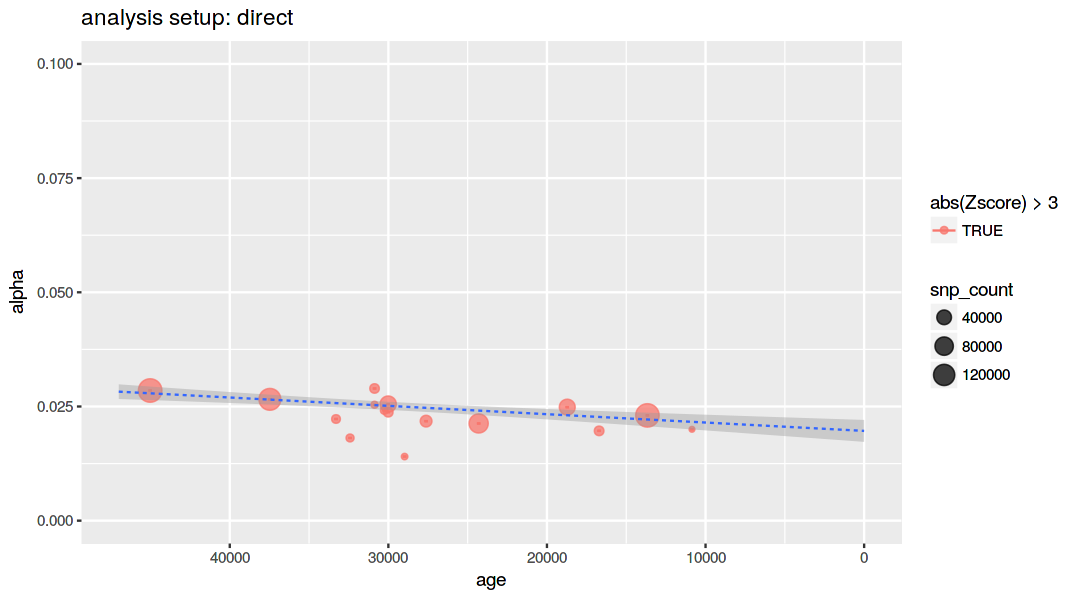

In [22]:
plot_nea_vs_time("direct", youngest=10000)
run_lm("direct", youngest=10000)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3240480  -761550   298609  1352439  4466496 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -66059       5856  -11.28 1.05e-14 ***
.[["alpha"]]  3543500     304402   11.64 3.62e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1951000 on 45 degrees of freedom
Multiple R-squared:  0.7507,	Adjusted R-squared:  0.7452 
F-statistic: 135.5 on 1 and 45 DF,  p-value: 3.616e-15


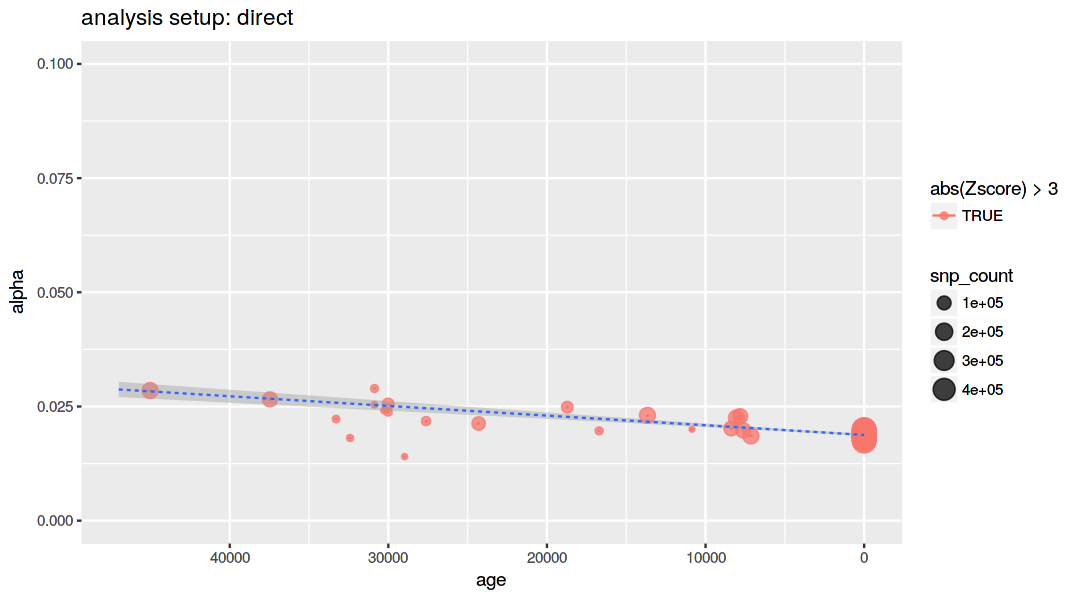

In [23]:
plot_nea_vs_time("direct")
run_lm("direct")

<font color="red">Note that we are actually showing 95% CI instead of just std errors, which are pretty meaningless by themselves (and are actually misleading, because they are small).</font>

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 38 rows containing missing values (geom_errorbar).”

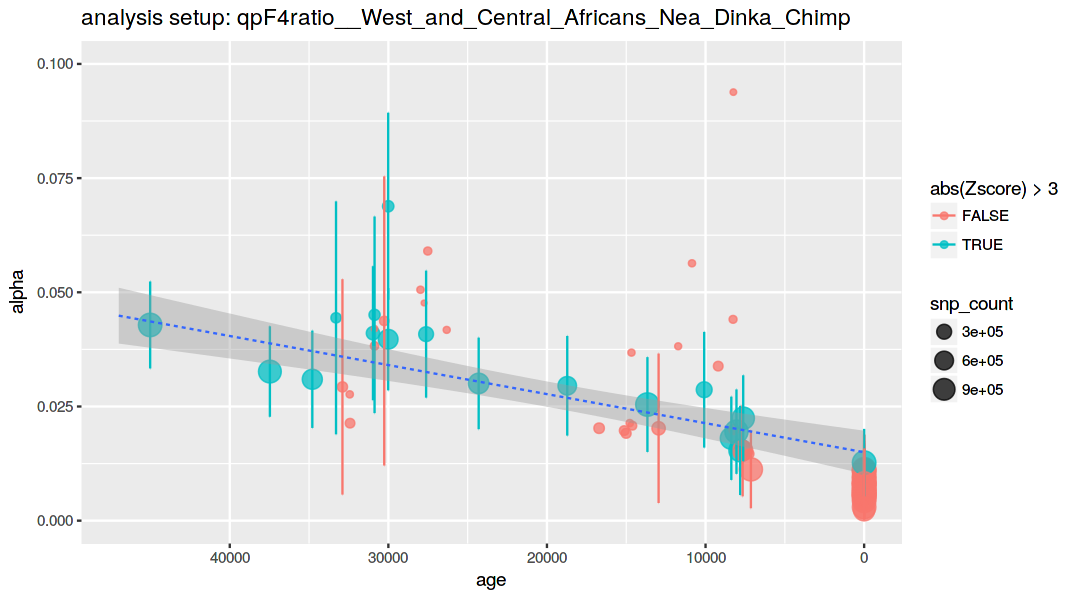

In [24]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp", ylim=c(0, 0.1))

# New f4 results

In [25]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7872488 -6199256   981672  3177320 40806624 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     12232       7619   1.606    0.113
.[["alpha"]]  -303071     384317  -0.789    0.433

Residual standard error: 9108000 on 70 degrees of freedom
Multiple R-squared:  0.008806,	Adjusted R-squared:  -0.005354 
F-statistic: 0.6219 on 1 and 70 DF,  p-value: 0.433


Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_errorbar).”

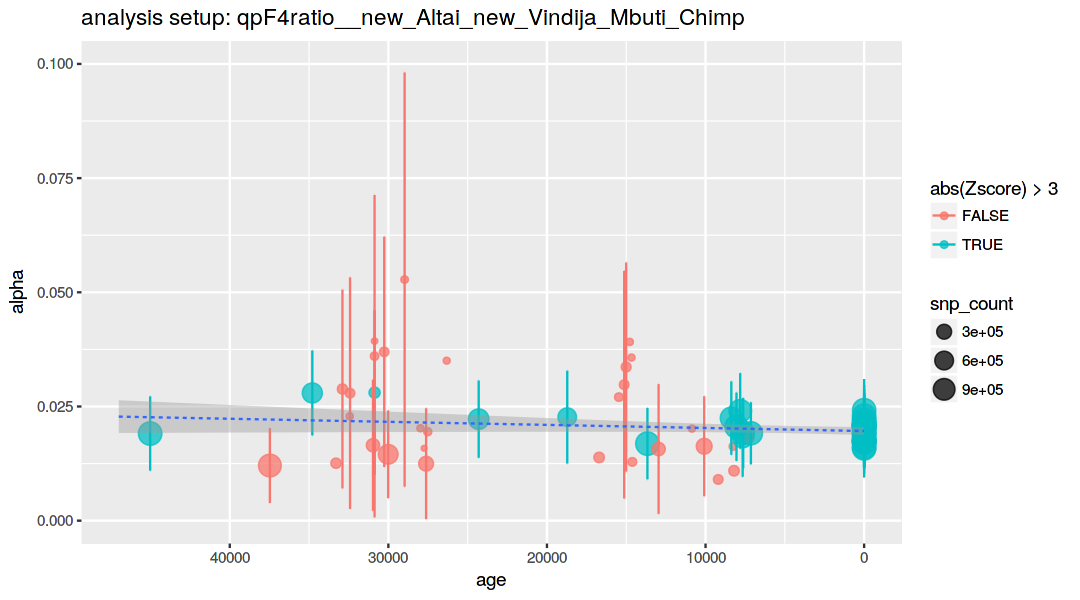

In [26]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7108983 -6422967   965201  2903612 41004733 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      3871       9207    0.42    0.675
.[["alpha"]]   103834     384984    0.27    0.788

Residual standard error: 9143000 on 70 degrees of freedom
Multiple R-squared:  0.001038,	Adjusted R-squared:  -0.01323 
F-statistic: 0.07274 on 1 and 70 DF,  p-value: 0.7882


Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 17 rows containing missing values (geom_errorbar).”

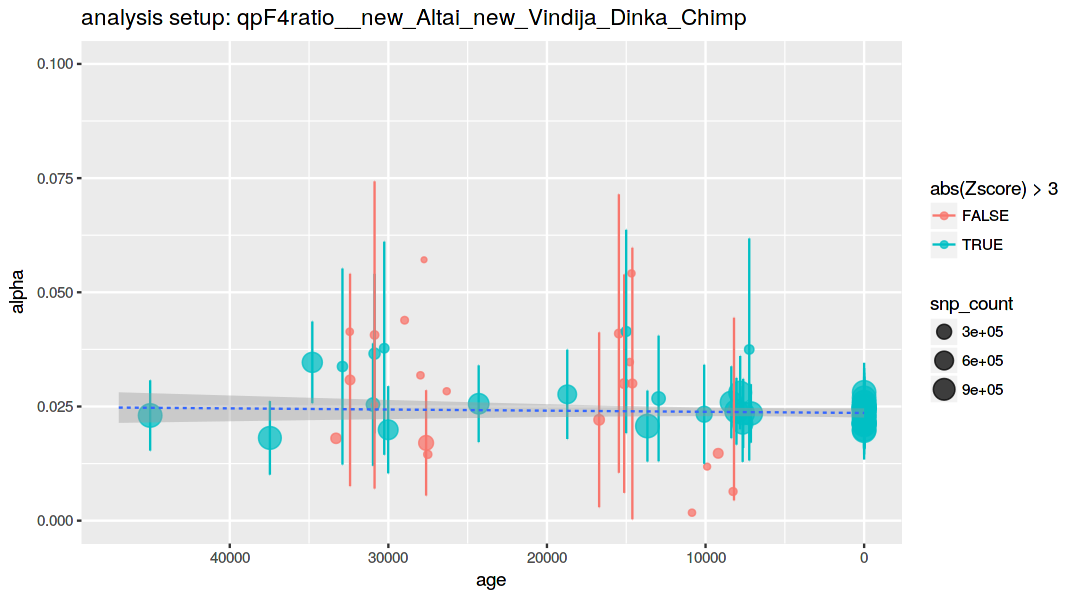

In [27]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-6738092 -6649588   869357  2985588 40944575 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      6093       8185   0.744    0.459
.[["alpha"]]    11040     383462   0.029    0.977

Residual standard error: 9148000 on 70 degrees of freedom
Multiple R-squared:  1.184e-05,	Adjusted R-squared:  -0.01427 
F-statistic: 0.000829 on 1 and 70 DF,  p-value: 0.9771


Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_errorbar).”

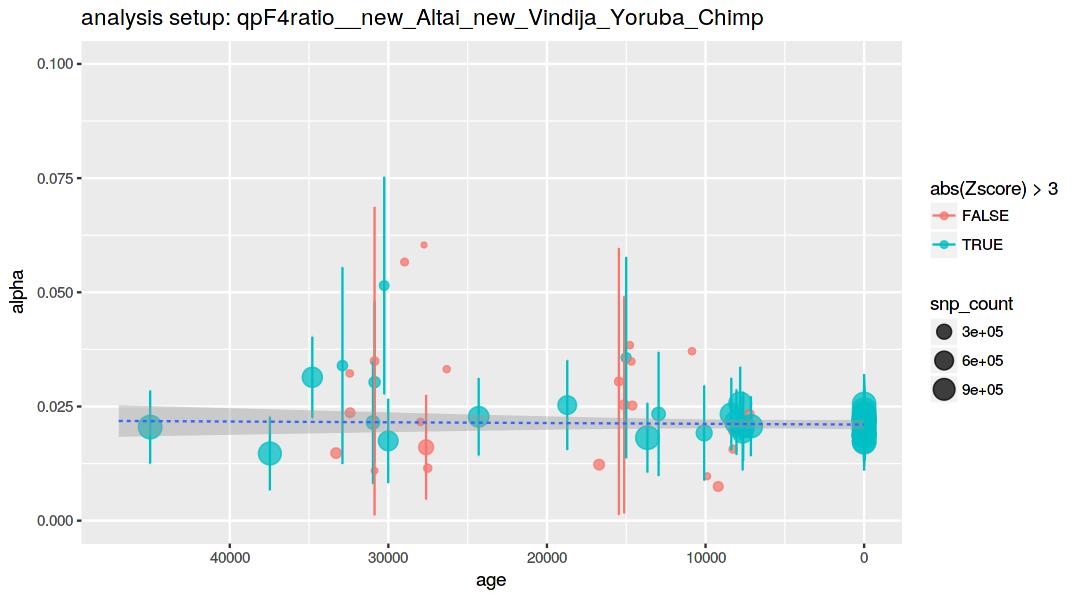

In [28]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")

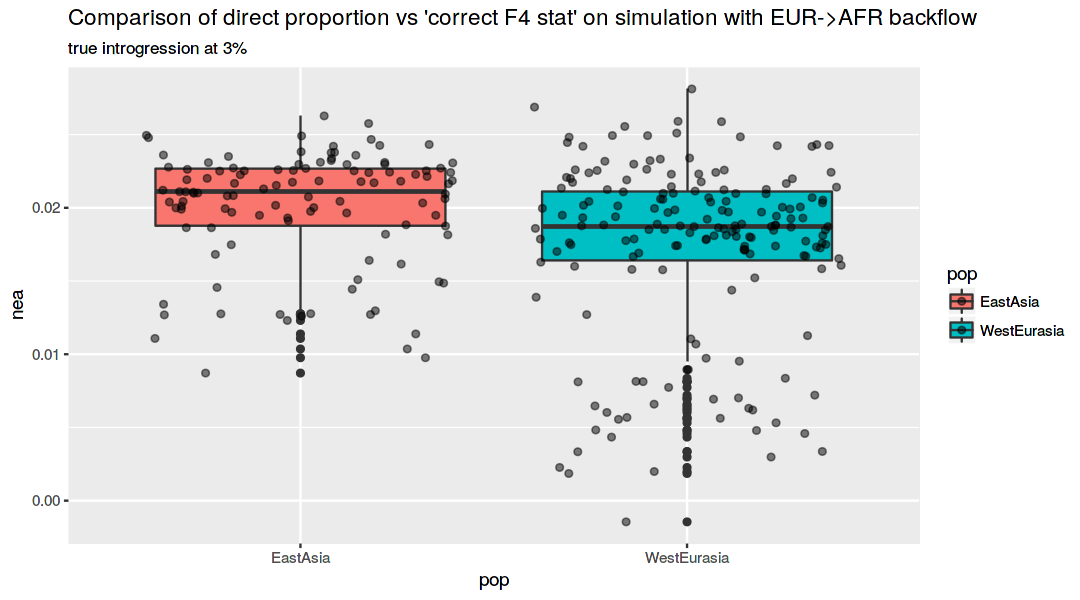

In [30]:
filter(all_nea_estimates, pop %in% c("WestEurasia", "EastAsia")) %>% select(pop, nea=alpha) %>%
    gather(pop, nea) %>%
    ggplot(aes(pop, nea, fill=pop)) + geom_boxplot() + geom_jitter(alpha=1/2) +
    ggtitle("Comparison of direct proportion vs 'correct F4 stat' on simulation with EUR->AFR backflow",
            "true introgression at 3%")

In [11]:
near_east_ids <- c("BedouinB", "Druze", "Iranian", "Iraqi_Jew", "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew")

In [12]:
non_ssudg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [43]:
mbuti  <- qpF4ratio(X=filter(samples, pop %in% c("EMH", "WestEurasia"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)

In [36]:
nea_d <- qpDstat(W="new_Altai",
                 X="new_Vindija",
                 Y=filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
                 Z="Mbuti",
                 prefix=EIGENSTRAT) %>%
    mutate(se=D / Zscore)

In [37]:
options(repr.plot.width=9, repr.plot.height=5)

In [60]:
filter(nea_d, Y %in% c("UstIshim", "Kostenki14", "Villabruna", "AfontovaGora3", "Satsurblia", "French")) %>% mutate(x=ABBA/BABA/n_snps)

W,X,Y,Z,D,Zscore,BABA,ABBA,n_snps,se,x
new_Altai,new_Vindija,UstIshim,Mbuti,-0.0283,-2.738,3863,4088,966375,0.010336012,1.095066e-06
new_Altai,new_Vindija,Kostenki14,Mbuti,-0.0312,-2.937,3604,3837,898633,0.010623085,1.184744e-06
new_Altai,new_Vindija,AfontovaGora3,Mbuti,-0.0558,-3.076,894,998,228133,0.018140442,4.893335e-06
new_Altai,new_Vindija,Villabruna,Mbuti,-0.0277,-2.417,3079,3254,750094,0.011460488,1.408939e-06
new_Altai,new_Vindija,Satsurblia,Mbuti,-0.0106,-0.902,2754,2814,675549,0.011751663,1.512528e-06
new_Altai,new_Vindija,French,Mbuti,-0.0346,-4.430,3888,4166,968651,0.007810384,1.106180e-06


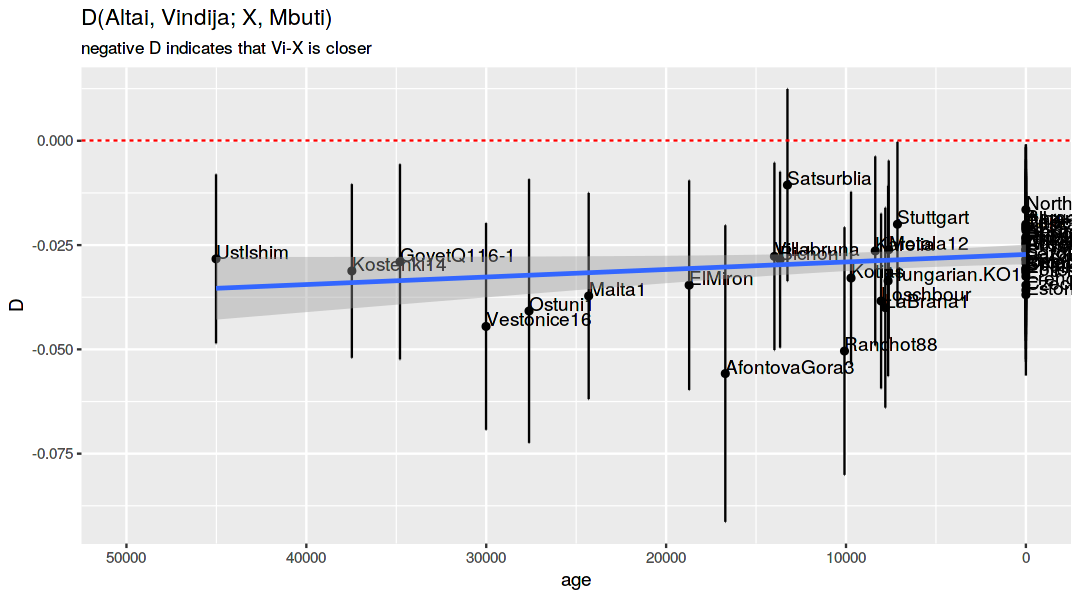

In [50]:
nea_d %>%
    inner_join(samples, by=c("Y"="name")) %>%
    filter(n_snps > 200000, !Y %in% near_east_ids) %>%
ggplot(aes(age, D)) +
    geom_point() +
    geom_text(aes(label=Y), hjust=0, vjust=0) +
    geom_errorbar(aes(ymin=D - 1.96 * se, ymax=D + 1.96 * se)) +
    geom_smooth(method="lm", aes(weight=n_snps)) +
    geom_hline(yintercept=0, linetype=2, color="red") +
    ggtitle("D(Altai, Vindija; X, Mbuti)",
            "negative D indicates that Vi-X is closer") +
    xlim(50000, 0)

In [64]:
g <- read_geno(GENO_FILE, IND_FILE)

In [73]:
select(g, new_Altai, new_Vindija) %>%
filter(! new_Altai %in% c(1, 9), ! new_Vindija %in% c(1, 9), new_Altai != new_Vindija) %>%
nrow

[1] 11399

In [74]:
11399/nrow(g)

[1] 0.01014248

In [24]:
x <- nea_d %>%
    inner_join(samples, by=c("Y"="name")) %>%
    filter(n_snps > 200000) %>% select(Y, D, age)

In [25]:
summary(lm(x$age ~ x$D))


Call:
lm(formula = x$age ~ x$D)

Residuals:
   Min     1Q Median     3Q    Max 
-11053  -7073  -3842   2239  37994 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)    -6225       6074  -1.025   0.3111  
x$D          -468250     197861  -2.367   0.0225 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11150 on 43 degrees of freedom
Multiple R-squared:  0.1152,	Adjusted R-squared:  0.09466 
F-statistic: 5.601 on 1 and 43 DF,  p-value: 0.02253
